# 1.1 Meteosat Second Generation (MSG) SEVIRI - Dust RGB - Level 1.5

### About

This notebook provides you an introduction to data from the SEVIRI instrument as part of the 0 Degree Service as well an introduction to the Python package [satpy](https://satpy.readthedocs.io/en/stable/) which allows for an efficient handling of data from meteorological satellite instruments, including SEVIRI and MODIS. At the end, a specific focus will be put on the [SEVIRI Dust RGB](https://user.eumetsat.int/resources/user-guides/dust-rgb-quick-guide), whose primary aim is to detect dust in the atmosphere.

The example features the Godzilla dust event on 14/19 June 2020, which brought massive amounts of Saharan dust all the way to the Caribbean and south-eastern parts of the continental US. See a more detailed description of this particular event [here](https://user.eumetsat.int/resources/case-studies/exceptional-saharan-dust-transport-over-the-atlantic).

The [Meteosat series](https://www.eumetsat.int/our-satellites/meteosat-series) have been providing crucial data for weather forecasting since 1977 and is a series of geostationary satellites providing imagery for weather forecasting and climate monitoring. [Meteosat Second Genersation (MSG)](https://www.eumetsat.int/meteosat-second-generation) is the current fleet of operational geostationary satellites. The [Spinning Enhanced Visible and InfraRed Imager (SEVIRI)](https://www.eumetsat.int/meteosat-second-gen-instruments) is MSG's primary instrument and has the capacity to observe the Earth in 12 spectral channels. 11 channels provides measurements with a resolution of 3 km at the sub-satellite and one, the High Resolution Visible (HRV) channel, provides measurements with a resolution of 1 km.

The SEVIRI instrument allows for a complete image scan (Full Earth Scan) every 15 minutes. The 0 Degree Service is the main mission of MSG and provides High Rate SEVIRI image data in 12 spectral bands, processed in near real-time to Level 1.5.


### Basic Facts

> **Spatial resolution**: `1 km at nadir`<br>
> **Spatial coverage**: `Latitude: -81 to 81 degrees`, `Longitude: -79 to 79 degrees` <br>
> **Revisit time**: `every 15 minutes` <br>
> **Data availability**: `since 2004`


### How to access the data

High Rate SEVIRI Level 1.5 Image Data - MSG - 0 degree data is available for download via the [EUMETSAT Data Store](https://data.eumetsat.int/data/map/EO:EUM:DAT:MSG:HRSEVIRI).

You need to register for the [EUMETSAT Earth Observation Portal](https://eoportal.eumetsat.int/) in order to be able to download data from the Data Store.


### Module outline
- [1 - Load and browse High Rate SEVIRI Level 1.5 Image Data - MSG - 0 degree](#load_msg)
- [2 - Browse and visualize RGB composite IDs](#rgb_composites_msg)
- [3 - Generate a geographical subset for southern Europe](#msg_geographical_subset)
- [4 - Visualize MSG 'natural_color' RGB composite with Cartopy features](#msg_visualize_natural_color)
- [5 - Load, visualize and interpret the MSG SEVIRI Dust RGB ](#msg_dust_rgb)

### Further resources

* [MSG 0-degree service](https://www.eumetsat.int/0-degree-service)
* [SEVIRI Dust RGB - Quick Guide](http://eumetrain.org/rgb_quick_guides/quick_guides/DustRGB.pdf)
* [Meteosat-11 captures plume of Saharan dust](https://www.eumetsat.int/meteosat-11-captures-saharan-dust-plume-from-northern-africa)
* [Meteosat series](https://www.eumetsat.int/our-satellites/meteosat-series)
* [Meteosat Second Generation](https://www.eumetsat.int/meteosat-second-generation)
* [SEVIRI Dust RGB Quick Guide](https://user.eumetsat.int/resources/user-guides/dust-rgb-quick-guide)

<hr>

#### Load required libraries

In [3]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf==1.3.0 satpy==0.51.0 pyhdf h5py python-geotiepoints

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.3/780.3 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.8/484.8 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.3/708.3 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.7 MB/s eta 0:00

In [4]:
import glob
import xarray as xr
import numpy as np
import tempfile

import os
#os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers

import pyresample

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [5]:
if os.path.exists("functions.ipynb"):
    %run functions.ipynb
elif os.path.exists("../functions.ipynb"):
    %run ../functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/functions.ipynb
    %run functions.ipynb

Helper functions notebook not found in any specified path. Downloading from Gitlab.
--2025-10-07 11:35:25--  https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/functions.ipynb
Resolving gitlab.eumetsat.int (gitlab.eumetsat.int)... 194.76.223.150
Connecting to gitlab.eumetsat.int (gitlab.eumetsat.int)|194.76.223.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36101 (35K) [text/plain]
Saving to: ‘functions.ipynb’

functions.ipynb     100%[===================>]  35.25K  --.-KB/s    in 0.1s    

2025-10-07 11:35:26 (336 KB/s) - ‘functions.ipynb’ saved [36101/36101]



In [6]:
if os.path.exists("bucket_functions.ipynb"):
    %run bucket_functions.ipynb
elif os.path.exists("../bucket_functions.ipynb"):
    %run ../bucket_functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/bucket_functions.ipynb
    %run bucket_functions.ipynb

Helper functions notebook not found in any specified path. Downloading from Gitlab.
--2025-10-07 11:35:32--  https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/bucket_functions.ipynb
Resolving gitlab.eumetsat.int (gitlab.eumetsat.int)... 194.76.223.150
Connecting to gitlab.eumetsat.int (gitlab.eumetsat.int)|194.76.223.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20508 (20K) [text/plain]
Saving to: ‘bucket_functions.ipynb’

bucket_functions.ip 100%[===================>]  20.03K  --.-KB/s    in 0.1s    

2025-10-07 11:35:32 (187 KB/s) - ‘bucket_functions.ipynb’ saved [20508/20508]



In [7]:
if not os.path.exists("coord2area_def.py"):
    print("coord2area_def functions notebook not found in any specified path. Downloading from Gitlab.")
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/01_dust/coord2area_def.py

coord2area_def functions notebook not found in any specified path. Downloading from Gitlab.
--2025-10-07 11:35:35--  https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/01_dust/coord2area_def.py
Resolving gitlab.eumetsat.int (gitlab.eumetsat.int)... 194.76.223.150
Connecting to gitlab.eumetsat.int (gitlab.eumetsat.int)|194.76.223.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5673 (5.5K) [text/plain]
Saving to: ‘coord2area_def.py’

coord2area_def.py   100%[===================>]   5.54K  --.-KB/s    in 0s      

2025-10-07 11:35:36 (68.0 MB/s) - ‘coord2area_def.py’ saved [5673/5673]



In [8]:
base_url = 'https://s3.waw3-2.cloudferro.com/swift/v1/wmo/'
all_paths_list = list_data_on_bucket(base_url)

all_directories_list = [os.path.dirname(path) for path in all_paths_list if path.count('/') <= 4]
# Take unique directories
all_directories_list = list(np.unique(all_directories_list))
all_directories_list

Status ok



[np.str_('eodata'),
 np.str_('eodata/fci'),
 np.str_('eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000'),
 np.str_('eodata/gome2'),
 np.str_('eodata/gome2/aai'),
 np.str_('eodata/gome2/hcho'),
 np.str_('eodata/gome2/hcho/daily'),
 np.str_('eodata/gome2/no2'),
 np.str_('eodata/gome2/no2/daily'),
 np.str_('eodata/iasi'),
 np.str_('eodata/iasi/co'),
 np.str_('eodata/iasi/nh3'),
 np.str_('eodata/meteosat'),
 np.str_('eodata/meteosat/2020'),
 np.str_('eodata/meteosat/2024'),
 np.str_('eodata/modis'),
 np.str_('eodata/modis/10km'),
 np.str_('eodata/modis/level_1b'),
 np.str_('eodata/monarch'),
 np.str_('eodata/pmap'),
 np.str_('eodata/s3'),
 np.str_('eodata/s3/aod'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240821T082340_20240821T082839_20240821T101507_0299_116_078______MAR_O_NR_003.SEN3'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240825T081954_20240825T082453_20240825T101112_0299_116_

#### Set geographical extent

In [9]:
latmin = 0
latmax = 40
lonmin = -50
lonmax = 20

<hr>

## <a id='load_msg'></a>1. Load and browse High Rate SEVIRI Level 1.5 Image Data - MSG - 0 degree

Meteosat Second Generation data are disseminated in the specific MSG Level 1.5 Native format. The Python package [satpy](https://satpy.readthedocs.io/en/stable/) supports reading and loading data from many input files. With the function `available_readers()`, you can get a list of all available readers satpy offers. For MSG data and the Native format, you can use the reader `seviri_l1b_native`.

In [10]:
available_readers()

['abi_l1b',
 'abi_l1b_scmi',
 'abi_l2_nc',
 'acspo',
 'agri_fy4a_l1',
 'agri_fy4b_l1',
 'ahi_hrit',
 'ahi_hsd',
 'ahi_l1b_gridded_bin',
 'ahi_l2_nc',
 'amsr2_l1b',
 'amsr2_l2',
 'amsr2_l2_gaasp',
 'amsub_l1c_aapp',
 'atms_l1b_nc',
 'atms_sdr_hdf5',
 'avhrr_l1b_aapp',
 'avhrr_l1b_eps',
 'avhrr_l1b_hrpt',
 'avhrr_l1c_eum_gac_fdr_nc',
 'clavrx',
 'cmsaf-claas2_l2_nc',
 'electrol_hrit',
 'epic_l1b_h5',
 'fci_l1c_nc',
 'fci_l2_nc',
 'geocat',
 'gerb_l2_hr_h5',
 'ghi_l1',
 'ghrsst_l2',
 'gld360_ualf2',
 'glm_l2',
 'gms5-vissr_l1b',
 'goci2_l2_nc',
 'goes-imager_hrit',
 'goes-imager_nc',
 'gpm_imerg',
 'hsaf_h5',
 'hy2_scat_l2b_h5',
 'iasi_l2',
 'iasi_l2_cdr_nc',
 'ici_l1b_nc',
 'jami_hrit',
 'li_l2_nc',
 'maia',
 'meris_nc_sen3',
 'mhs_l1c_aapp',
 'mimicTPW2_comp',
 'mirs',
 'modis_l1b',
 'modis_l2',
 'modis_l3',
 'msi_safe',
 'msi_safe_l2a',
 'msu_gsa_l1b',
 'mtsat2-imager_hrit',
 'mviri_l1b_fiduceo_nc',
 'mwi_l1b_nc',
 'mws_l1b_nc',
 'nucaps',
 'nwcsaf-geo',
 'nwcsaf-msg2013-hdf5',
 'nwcsa

<br>

From the [EUMETSAT Data Store](https://data.eumetsat.int/data/map/EO:EUM:DAT:MSG:HRSEVIRI?start=2020-06-14T00:27:00.000Z&end=2020-06-19T23:27:00.000Z&page=26,20&sort=start,time,0), we downloaded for severals hours from 14 to 19 June 2020 of High Rate SEVIRI Level 1.5 Image data.
Let us load one image scence for 19 June 2020 at 9.42 UTC.

Unfortunately,`satpy` cannot directly open files from an object storage service without first downloading the files locally. `satpy` expects local file paths to work with, as it reads files from disk. You can use the function `download_data_from_bucket()`.

In [11]:
data_paths = [path for path in all_paths_list if 'NA-20200619' in path]
data_paths

['eodata/meteosat/2020/MSG4-SEVI-MSG15-0100-NA-20200619094243.429000000Z-NA.nat']

In [12]:
download_directory = "../../downloads/"
file_names = download_data_from_bucket(base_url, data_paths, download_directory)

Downloaded file: ../../downloads/MSG4-SEVI-MSG15-0100-NA-20200619094243.429000000Z-NA.nat


In [13]:
file_names

['../../downloads/MSG4-SEVI-MSG15-0100-NA-20200619094243.429000000Z-NA.nat']

In a next step, we use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for MSG SEVIRI data in the Native format, you can use the `seviri_l1b_native` reader.

In [14]:
scn = Scene(reader="seviri_l1b_native",
             filenames=file_names)
scn

<br>

A `Scene` object loads all band information of a satellite image. With the function `available_dataset_names()`, you can see the available bands available from the MSG SEVIRI satellite.

In [15]:
scn.available_dataset_names()

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

<br>

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `IR_108` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`.

In [16]:
scn.load(['IR_108'])
scn['IR_108']

<xarray.DataArray 'reshape-9e9464eb3ce081fb0b09672ed7dca9a9' (y: 3712, x: 3712)> Size: 110MB
dask.array<truediv, shape=(3712, 3712), dtype=float64, chunksize=(460, 3712), chunktype=numpy.ndarray>
Coordinates:
    acq_time  (y) datetime64[ns] 30kB NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    crs       object 8B PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknow...
  * y         (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x         (x) float64 30kB 5.566e+06 5.563e+06 ... -5.566e+06 -5.569e+06
Attributes: (12/18)
    orbital_parameters:       {'projection_longitude': np.float32(0.0), 'proj...
    units:                    K
    wavelength:               10.8 µm (9.8-11.8 µm)
    standard_name:            toa_brightness_temperature
    platform_name:            Meteosat-11
    sensor:                   seviri
    ...                       ...
    name:                     IR_108
    resolution:               3000.403165817
    calibration:              brightness_temperature
    modifiers:                ()
    _satpy_id:                DataID(name='IR_108', wavelength=WavelengthRang...
    ancillary_variables:      []

<br>

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`.

In [17]:
scn['IR_108'].attrs.keys()

dict_keys(['orbital_parameters', 'units', 'wavelength', 'standard_name', 'platform_name', 'sensor', 'georef_offset_corrected', 'time_parameters', 'start_time', 'end_time', 'reader', 'area', 'name', 'resolution', 'calibration', 'modifiers', '_satpy_id', 'ancillary_variables'])

<br>

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [18]:
scn['IR_108'].attrs['start_time'], scn['IR_108'].attrs['end_time']

(datetime.datetime(2020, 6, 19, 9, 30), datetime.datetime(2020, 6, 19, 9, 45))

<br>

But for now, let us reload the data file from the beginning. We do not need the `IR_108` channel for the next steps, but rather would like to focus on different `RGB composites`.

In [19]:
scn = Scene(reader="seviri_l1b_native",
             filenames=file_names)
scn

<br>

## <a id='rgb_composites_msg'></a> 2. Browse and visualize RGB composite IDs

RGB composites combine multiple window channels of satellite data in order to get e.g. a true-color image of the scene. Depending on the channel combination used, different features can be highlighted in the composite, e.g. dust. SatPy offers several predefined RGB composites options. The function `available_composite_ids()` returns a list of available composite IDs. You see that there are predefined composites for e.g. `natural_color`, `snow` or `dust`.

In [20]:
scn.available_composite_ids()

[DataID(name='24h_microphysics'),
 DataID(name='airmass'),
 DataID(name='ash'),
 DataID(name='cloud_phase_distinction'),
 DataID(name='cloud_phase_distinction_raw'),
 DataID(name='cloudtop'),
 DataID(name='cloudtop_daytime'),
 DataID(name='colorized_ir_clouds'),
 DataID(name='convection'),
 DataID(name='day_microphysics'),
 DataID(name='day_microphysics_winter'),
 DataID(name='dust'),
 DataID(name='fog'),
 DataID(name='green_snow'),
 DataID(name='hrv_clouds'),
 DataID(name='hrv_fog'),
 DataID(name='hrv_severe_storms'),
 DataID(name='hrv_severe_storms_masked'),
 DataID(name='ir108_3d'),
 DataID(name='ir_cloud_day'),
 DataID(name='ir_overview'),
 DataID(name='ir_sandwich'),
 DataID(name='natural_color'),
 DataID(name='natural_color_nocorr'),
 DataID(name='natural_color_raw'),
 DataID(name='natural_color_raw_with_night_ir'),
 DataID(name='natural_color_with_night_ir'),
 DataID(name='natural_color_with_night_ir_hires'),
 DataID(name='natural_enh'),
 DataID(name='natural_enh_with_night_ir')

<br>

Let us define a list with the composite ID `natural_color`. This list (`composite_id`) can then be passed to the function `load()`. Per default, scenes are loaded with the north pole facing downwards. You can specify the keyword argument `upper_right_corner="NE"` in order to turn the image around and have the north pole facing upwards.

In [21]:
composite_id = ['natural_color']
scn.load(composite_id, upper_right_corner="NE")

<br>

A print of the Scene object `scn` shows you that it consists of one `xarray.DataArray` with the standard name `natural_color`.

In [22]:
print(scn)

<xarray.DataArray 'where-bf2ead3770dc8434dfa19298f8b90ac9' (bands: 3, y: 3712,
                                                            x: 3712)> Size: 331MB
dask.array<where, shape=(3, 3712, 3712), dtype=float64, chunksize=(1, 460, 3712), chunktype=numpy.ndarray>
Coordinates:
    crs      object 8B PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown...
  * y        (y) float64 30kB 5.569e+06 5.566e+06 ... -5.563e+06 -5.566e+06
  * x        (x) float64 30kB -5.569e+06 -5.566e+06 ... 5.563e+06 5.566e+06
  * bands    (bands) <U1 12B 'R' 'G' 'B'
Attributes: (12/20)
    area:                                   Area ID: msg_seviri_fes_3km\nDesc...
    time_parameters:                        {'nominal_start_time': datetime.d...
    reader:                                 seviri_l1b_native
    sun_earth_distance_correction_factor:   1.0160823678570055
    sensor:                                 seviri
    georef_offset_corrected:                True
    ...                               

<br>

The function `show()` allows you to visualize a loaded composite or band. Let us e.g. visualize the `natural_color` composite. Once visualized, you see that the RGB composite highlights clouds in turquoise, but highlights specific features in their natural color.

In [23]:
scn.show('natural_color')

Output hidden; open in https://colab.research.google.com to view.

<br>

## <a id='msg_geographical_subset'></a>3. Generate a geographical subset for North Africa and Atlantic Ocean

The visualization above looks nice, but in many cases you might want to highlight a specific geographical region. Let us generate a geographical subset for southern Europe. You can do this with the function `crop()` and specifying the keyword argument `ll_bbox=(lonmin, latmin, lonmax, latmax)`.

Afterwards, you can visualize the cropped image with the function `show()`.

In [24]:
scn_cropped = scn.crop(ll_bbox=(lonmin, latmin, lonmax, latmax))
scn_cropped.show("natural_color")

Output hidden; open in https://colab.research.google.com to view.

<br>

From the cropped image, you can load the `area` information that is stored as an attribute entry. The `area` attribute holds information related to the `projection`, `number of columns / rows` and `area extent`.

**Note**: the `area extent` key provides x and y values in meters from the nadir, which is the original projection unit.

In [25]:
scn_cropped['natural_color'].attrs['area']

Area ID: msg_seviri_fes_3km
Description: MSG SEVIRI Full Earth Scanning service area definition with 3 km resolution
Projection: {'a': '6378169', 'h': '35785831', 'lon_0': '0', 'no_defs': 'None', 'proj': 'geos', 'rf': '295.488065897014', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2224
Number of rows: 1282
Area extent: (np.float32(-4550111.5), np.float32(19503.0), np.float32(2122785.0), np.float32(3866019.8))

<br>

Another possibility is to crop the data with x and y values in original projection unit (x_min, y_min, x_max, y_max). In the case of MSG SEVIRI data, the projection unit is meters (distance from the nadir). Below we apply the funcion `crop()` again, but instead of `ll_bbox`, we use this time the keyword argument `xy_bbox=(xmin, ymin, xmax, ymax)` and slightly adjust the x and y values from the `area extent` attribute above.

When we visualize the cropped image again with the function `show()`, you see that the extent is more or less the same. The adjustment of `ymin` and `ymax` has increased the extent towards the north and the south.

In [26]:
scn_cropped = scn.crop(xy_bbox=(-4550111.401, 19502.6206, 2122785.2398, 3866019.4792))
scn_cropped.show("natural_color")

Output hidden; open in https://colab.research.google.com to view.

<br>

As a next step, let us store the area definition as variable and call it `area`. We can can use the area information to resample the loaded scene object in a next step.

In [27]:
area = scn_cropped['natural_color'].attrs['area']
area

Area ID: msg_seviri_fes_3km
Description: MSG SEVIRI Full Earth Scanning service area definition with 3 km resolution
Projection: {'a': '6378169', 'h': '35785831', 'lon_0': '0', 'no_defs': 'None', 'proj': 'geos', 'rf': '295.488065897014', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2225
Number of rows: 1283
Area extent: (np.float32(-4550111.5), np.float32(16502.5), np.float32(2125785.0), np.float32(3866019.8))

<br>

Cropping is nice and for our geographical area of interest the cropped image looks acceptable. However, when working with regions close to the marging of the scene, the cropped scene can look very distorted, due to the viewing angle of the satellite. For this reason, it is recommended to use the function `resample()` from the library [pyresample](https://pyresample.readthedocs.io/en/latest/), which resamples the loaded scene to a custom area and projection.

Pyresample offers predefined areas; a list of those can be found in the satpy package under /satpy/etc/ in the file `areas.yaml`. There is no predefined area for our region. For this reason, we can make use of the variable `area`, which we defined above and which has all the area information needed by the `resample()` function. Below, we simply pass the `area` variable to the `resample()` function.

In [28]:
scn_resample_nc = scn.resample(area)
scn_resample_nc.show('natural_color')

Output hidden; open in https://colab.research.google.com to view.

<br>

## <a id='msg_visualize_natural_color'></a> 4. Visualize MSG *natural_color* RGB composite with Cartopy features

SatPy's built-in visualization function is nice, but often you want to make use of additonal features, such as country borders. The library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) offers powerful functions that enable the visualization of geospatial data in different projections and to add additional features to a plot. Below, we will show you how you can visualize the `natural_color` composite with the two Python packages [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

As a first step, we have to convert the `Scene` object into a numpy array. The numpy array additionally needs to be transposed to a shape that can be interpreted by matplotlib's function `imshow()`: (M,N,3). You can convert a Scene object into a `numpy.array` object with the function `np.asarray()`.

The shape of the array is `(3, 1283, 2225)`. This means we have to transpose the array and add index=0 on index position 3.

In [29]:
image = np.asarray(scn_resample_nc["natural_color"]).transpose(1,2,0)
image.shape

(1283, 2225, 3)

<br>

In a next step, we scale the values to a range between 0 and 1 and we clip the lower and upper percentiles. This process sharpens the contrast, as a potential contrast decrease caused by outliers is eliminated.

In [30]:
image = np.interp(image, (np.nanpercentile(image,1), np.nanpercentile(image,99)), (0, 1))

<br>

Let us now also define a variable for the `coordinate reference system`. We take the `area` attribute from she `scn_resample_nc` Scene and convert it with the function `to_cartopy_crs()` into a format Cartopy can read. We will use the `crs` information for plotting.

In [31]:
crs = scn_resample_nc["natural_color"].attrs["area"].to_cartopy_crs()

<br>

Now, we can visualize the `natural_color` composite. The plotting code can be divided in four main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the numpy array with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

Text(0.5, 1.0, 'Natural color composite over North Africa and Atlantic Ocean, recorded by MSG at 2020-06-19 09:30')

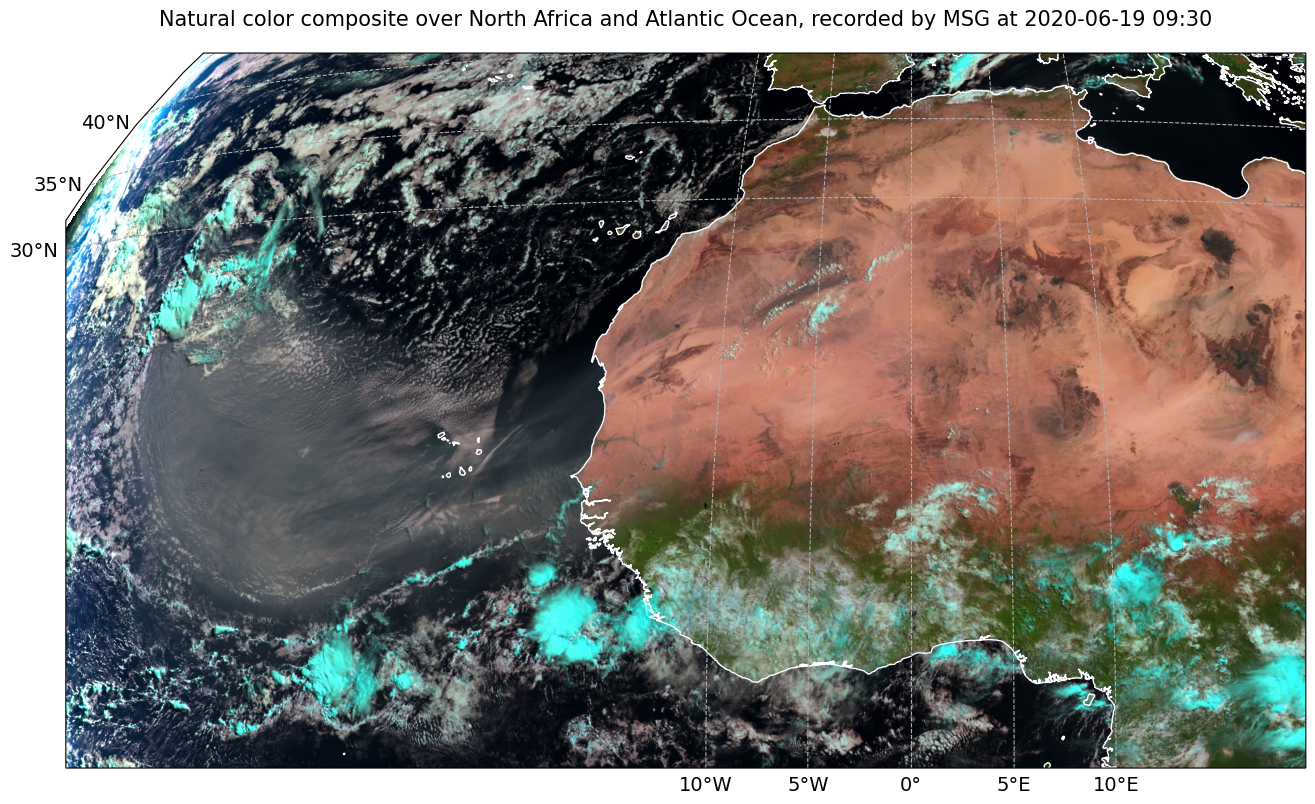

In [32]:
# Initiatie a subplot and axes with the CRS information previously defined
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Add coastline features to the plot
ax.coastlines(resolution="10m", color="white")

# Define a grid to be added to the plot
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(-10,11,5), ylocs=range(30,50,5))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# In the end, we can plot our image data...
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# Define a title for the plot
plt.title("Natural color composite over North Africa and Atlantic Ocean, recorded by MSG at " + scn_resample_nc.start_time.strftime("%Y-%m-%d %H:%M"), fontsize=15, pad=20.0)


<br>

## <a id='msg_dust_rgb'></a>5. Load, visualize and interpret the MSG SEVIRI Dust RGB

In a final step, we would like to have a closer look at the [SEVIRI Dust RGB](https://user.eumetsat.int/resources/user-guides/dust-rgb-quick-guide) composite, whose primary aim is to support the detection of dust in the atmosphere.
The dust composite makes use of three window channels of Meteosat Second Generation:
* **Red**: `IR12.0-IR10.8`
* **Green**: `IR10.8-IR.8.7`
* **Blue**: `IR10.8`

Let us first again load the image from 19 June 2020 at 9.42 UTC as a pytroll `Scene` object again.

In [33]:
scn = Scene(reader="seviri_l1b_native",
             filenames=file_names)
scn

<br>

Now, let us define a list with the predefined `dust` RGB composite and let us load this composite with the function `load()`. You can specify the keyword argument `upper_right_corner="NE"` in order to turn the image around and have the north pole facing upwards.

In [34]:
composite_id = ['dust']
scn.load(composite_id, upper_right_corner="NE")

<br>

The, we can directly `resample` the image to the area defined above. You can use the `area` object and the function `resample()` to resample the dust RGB composite to the area of interest.

In [35]:
scn_resample_dust = scn.resample(area)


<br>

And in a last step, we can visualize the dust composite with Satpy's built-in visualization function `show()`. The colours of the dust RGB can be interpreted as follows:
* `Magenta`: Dust or ash clouds
* `Black`: Cirrus clouds
* `Dark red`: Thick, high and cold ice clouds
* `Yellow`: Thick mid-level clouds
* `Darkblue`: Humid air in lower levels
* `Lilac`: Dry air in lower levels

Get more information about the Dust RGB in the [SEVIRI Dust RGB Quick Guide](https://user.eumetsat.int/resources/user-guides/dust-rgb-quick-guide).

The dust composite of 19 June shows clearly that a dust cloud is coming from the Sahara towards the Atlantic Ocean.

In [36]:
scn_resample_dust.show('dust')

Output hidden; open in https://colab.research.google.com to view.

<hr>

### References
* High Rate SEVIRI Level 1.5 Image Data - MSG - 0 degree (Source: EUMETSAT)

* This notebook was adapted from: https://dustbook.ltpy.adamplatform.eu/docs/msg_rgb.html

* Some code in this notebook was adapted from the following sources:
  * origin: https://python-kurs.github.io/sommersemester_2019/units/S01E07.html
  * copyright: 2019, Marburg University
  * license: CC BY-SA 4.0
  * retrieved: 2024-05-03 Julia Wagemann


<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under <a href="../../LICENSE">GNU General Public License v3.0 only</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>